<a href="https://colab.research.google.com/github/adeeb99/ME491/blob/main/Copy_of_main_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semantic Segmentation

In [3]:
! git clone https://github.com/sunghoonYoon/Kitti_TA

from google.colab import drive
drive.mount('/content/drive')

####NOTE: you should change the "runtime option to use GPU"

fatal: destination path 'Kitti_TA' already exists and is not an empty directory.


In [4]:
# Kitti_options = NONE #SS: Semantic Segmentation , SM: Stereo Matching, OF: Optical flow /// Only these three options are available

# assert Kitti_options in ['SS','SM','OF']

from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import numpy as np

from collections import OrderedDict
import time
from imageio import imread, imwrite

########
from Kitti_TA.kitti_seg import decode_segmap, denorm, DeepWV3Plus ##import segmentation network (deeplabWplus)
from Kitti_TA.kitti_stereo import PSMNet #import stereo matching network
from Kitti_TA.kitti_flow import ArrayToTensor, flow2rgb, FlowNetS #import flow network


left0_image_path = '/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/2011_09_26_drive_0096_sync/image_02/data/0000000000.png'
right0_image_path = '/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/2011_09_26_drive_0096_sync/image_03/data/0000000000.png'

left1_image_path = '/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/2011_09_26_drive_0096_sync/image_02/data/0000000001.png'




Semantic Segmentation

=====================Could not load ImageNet weights=======================
Please download the ImageNet weights of WideResNet38 in our repo to ./pretrained_models.


C:\Users\adeeb\anaconda3\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


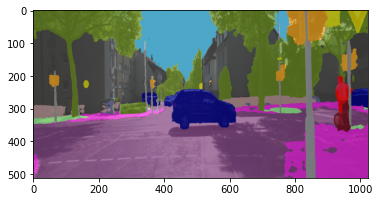

In [6]:

net_SS = DeepWV3Plus(num_classes=19).cuda() # declare Network and the number of class=19
state_dict= torch.load('/content/drive/MyDrive/Kitti/TA_segmentation-20211123T105326Z-001/TA_segmentation/cityscapes_best.pth')
net_SS = torch.nn.DataParallel(net_SS)
    
net_SS.load_state_dict(state_dict['state_dict'],strict=False) #load the checkpoint(state_dict) 

net_SS.eval()

# image= np.asarray(Image.open(left0_image_path)).convert('RGB')
image= np.asarray(Image.open(left0_image_path).convert('RGB'))
MEAN = [0.45734706, 0.43338275, 0.40058118]
STD = [0.23965294, 0.23532275, 0.2398498]

toTensor = transforms.ToTensor()
normTensor = transforms.Normalize(MEAN,STD)
imageT = normTensor(toTensor(image))

with torch.no_grad():
    
    imageT = F.interpolate(imageT.unsqueeze(0), size=(512,1024),mode='bilinear',align_corners=True)
    # YOUR_IMPLEMENTATION # get segmentation results using network
    out = net_SS(imageT.cuda())
    # YOUR_IMPLEMENTATION # Take softmax to the network output in channel dimension
    prob = F.softmax(out,1)
    # YOUR_IMPLEMENTATION # Get max indices from the softmax-ed result (use argmax function)
    pred = np.argmax(prob[0].detach().cpu().numpy(),axis=0)
segmap = decode_segmap(pred) #use the function that we provide (convert prediction into RBG color map)

###Visualization###
'''
YOUR IMPLEMENTATION
#Visualize the segmentation result and image together with transparency (alpha=0.7) mode. use plt function

''' 

plt.imshow(denorm(imageT)[0].permute(1,2,0))
plt.imshow(segmap,alpha=0.7)
plt.show()

Stereo matching

In [7]:

max_disp = 192
net_SM = PSMNet(max_disp) # declare Network and the max disparity is 192
net_SM = net_SM.cuda()
net_SM.eval()

checkpoint = torch.load('/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/pretrained_model_KITTI2015.tar')
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[7:]
    new_state_dict[name] = v    
net_SM.load_state_dict(new_state_dict)    
normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}
infer_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(**normal_mean_var)])    


imgL_o = Image.open(left0_image_path).convert('RGB')
imgR_o = Image.open(right0_image_path).convert('RGB')

imgL = infer_transform(imgL_o)
imgR = infer_transform(imgR_o) 

# pad to width and hight to 16 times
if imgL.shape[1] % 16 != 0:
    times = imgL.shape[1]//16       
    top_pad = (times+1)*16 -imgL.shape[1]
else:
    top_pad = 0

if imgL.shape[2] % 16 != 0:
    times = imgL.shape[2]//16                       
    right_pad = (times+1)*16-imgL.shape[2]
else:
    right_pad = 0    

imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

start_time = time.time()

net_SM.eval()

imgL = imgL.cuda()
imgR = imgR.cuda()  
        

with torch.no_grad():
    disp = net_SM(imgL,imgR) # get output from the network, input: (imgL,imgR)

    disp = torch.squeeze(disp)
    pred_disp = disp.data.cpu().numpy()


if top_pad !=0 or right_pad != 0:
    img = pred_disp[top_pad:,:-right_pad]
else:
    img = pred_disp

####Visualize####
'''
YOUR IMPLEMENTATION
#Visualize the left image and left disparity using plt function.

'''
plt.figure()
plt.title('left image')
plt.imshow(imgL_o)
plt.figure()
plt.title('disparity output')
plt.imshow(imgL_o)
plt.imshow(img,alpha=0.7)
plt.show()
    

C:\Users\adeeb\anaconda3\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\adeeb\anaconda3\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\adeeb\anaconda3\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


RuntimeError: ignored

optical flow

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/Kitti/TA_flow-20211123T105433Z-001/TA_flow/flownets_bn_EPE2.459.pth.tar')

net_OF = FlowNetS(batchNorm=True) # declare Network for optical flow
net_OF = net_OF.cuda()
net_OF.eval()

input_transform = transforms.Compose([
    ArrayToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
    transforms.Normalize(mean=[0.411,0.432,0.45], std=[1,1,1])
])


img1= input_transform(imread(left0_image_path))
img2= input_transform(imread(left1_image_path))

input_var = torch.cat([img1, img2]).unsqueeze(0) # concatenate "img1" and "img2" and expand zero dimentions so that the dimension (1,C,H,W)

net_OF.load_state_dict(state_dict['state_dict'])

bidirectional = True
if bidirectional:
    # feed inverted pair along with normal pair
    inverted_input_var = torch.cat([img2, img1]).unsqueeze(0) # concatenate "img2" and "img1" and expand zero dimentions so that the dimension (1,C,H,W), Note that the order (img2,img1) is important
    input_var = torch.cat([input_var, inverted_input_var])

input_var = input_var.cuda()
# compute output
flow_output = net_OF(input_var) #Get optical flow network output (input: input_var)

rgb_flow = flow2rgb(20 * flow_output[0], max_value=20)
rgb_inv_flow = flow2rgb(20 * flow_output[1], max_value=20)
to_save = (rgb_flow * 255).astype(np.uint8).transpose(1,2,0)
to_save_inv = (rgb_inv_flow * 255).astype(np.uint8).transpose(1,2,0)

plt.figure()
plt.title('flow result')
plt.imshow(to_save)
plt.show()

plt.figure()
plt.title('inv flow result')
plt.imshow(to_save_inv)
plt.show()


Saving results

In [ ]:
file_dir_L = '/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/2011_09_26_drive_0096_sync/image_02/data/*.png'
file_dir_R = '/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/2011_09_26_drive_0096_sync/image_03/data/*.png'

save_dir_SS = '/content/drive/MyDrive/Kitti/TA_segmentation-20211123T105326Z-001/TA_segmentation/output'
save_dir_SM = '/content/drive/MyDrive/Kitti/TA_stereo-20211123T105355Z-001/TA_stereo/output'
save_dir_OF = '/content/drive/MyDrive/Kitti/TA_flow-20211123T105433Z-001/TA_flow/output'
save_dir_OF_inv = '/content/drive/MyDrive/Kitti/TA_flow-20211123T105433Z-001/TA_flow/inverse_output'

import glob
import os
import cv2

files_L = glob.glob(file_dir_L)
files_R = glob.glob(file_dir_R)
save_SS = glob.glob(save_dir_SS+'/*.png')

'''
This is manual (incompleted code) for you to convert output into video.
1) extract the output and save it to png.
2) used cv2.VideoWriter function to make video from png image files
3) Make Video for all 3 tasks (Semantic Segmetnation /Stereo Matching/ Optical Flow)

'''


# stereo_file = [files_L,files_R]
# i=0
for i in range(len(files_L)):
  with torch.no_grad():
    image = np.asarray(Image.open(files_L[i]).convert('RGB'))
    # image_R = np.asarray(Image.open(files_R[i]).convert('RGB'))

    ## SS
    imageT = normTensor(toTensor(image))
    imageT = F.interpolate(imageT.unsqueeze(0), size=(512,1024),mode='bilinear',align_corners=True)
    out_seg = net_SS(imageT.cuda())
    '''YOUR IMPLEMENTATION''' #Get output 
    prob = F.softmax(out_seg,1)
    pred = np.argmax(prob[0].detach().cpu().numpy(),axis=0)
    segmap = decode_segmap(pred) 
    plt.imshow(denorm(imageT)[0].permute(1,2,0))
    plt.imshow(segmap,alpha=0.7)
    plt.savefig(os.path.join(save_dir_SS,os.path.basename(files_L[i])))
    plt.show()
    plt.close()
    

    ##SM
    imgL_o = Image.open(files_L[i]).convert('RGB')
    imgR_o = Image.open(files_R[i]).convert('RGB')

    imgL = infer_transform(imgL_o)
    imgR = infer_transform(imgR_o) 

    # pad to width and hight to 16 times
    if imgL.shape[1] % 16 != 0:
        times = imgL.shape[1]//16       
        top_pad = (times+1)*16 -imgL.shape[1]
    else:
        top_pad = 0

    if imgL.shape[2] % 16 != 0:
        times = imgL.shape[2]//16                       
        right_pad = (times+1)*16-imgL.shape[2]
    else:
        right_pad = 0    

    imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
    imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

    # start_time = time.time()

    net_SM.eval()

    imgL = imgL.cuda()
    imgR = imgR.cuda()  
            

    with torch.no_grad():
        disp = net_SM(imgL,imgR) # get output from the network, input: (imgL,imgR)

        disp = torch.squeeze(disp)
        pred_disp = disp.data.cpu().numpy()


    if top_pad !=0 or right_pad != 0:
        img = pred_disp[top_pad:,:-right_pad]
    else:
        img = pred_disp

    ####Visualize####
    '''
    YOUR IMPLEMENTATION
    #Visualize the left image and left disparity using plt function.

    '''
    # plt.figure()
    # plt.title('left image')
    # plt.imshow(imgL_o)
    plt.figure()
    # plt.title('disparity output')
    plt.imshow(imgL_o)
    plt.imshow(img,alpha=0.7)
    plt.savefig(os.path.join(save_dir_SM,os.path.basename(files_L[i])))
    plt.show()    
    plt.close()

    ##OF
    if i != len(files_L):
      img1= input_transform(imread(files_L[i]))
      img2= input_transform(imread(files_L[i+1]))
      input_var = torch.cat([img1, img2]).unsqueeze(0) # concatenate "img1" and "img2" and expand zero dimentions so that the dimension (1,C,H,W)
      if bidirectional:
        # feed inverted pair along with normal pair
        inverted_input_var = torch.cat([img2, img1]).unsqueeze(0) # concatenate "img2" and "img1" and expand zero dimentions so that the dimension (1,C,H,W), Note that the order (img2,img1) is important
        input_var = torch.cat([input_var, inverted_input_var])

      input_var = input_var.cuda()
      # compute output
      flow_output = net_OF(input_var) #Get optical flow network output (input: input_var)

      rgb_flow = flow2rgb(20 * flow_output[0], max_value=20)
      rgb_inv_flow = flow2rgb(20 * flow_output[1], max_value=20)
      to_save = (rgb_flow * 255).astype(np.uint8).transpose(1,2,0)
      to_save_inv = (rgb_inv_flow * 255).astype(np.uint8).transpose(1,2,0)

      plt.figure()
      plt.title('flow result')
      plt.imshow(to_save)
      plt.savefig(os.path.join(save_dir_OF,os.path.basename(files_L[i])))
      plt.show()
      plt.close()

      plt.figure()
      plt.title('inv flow result')
      plt.imshow(to_save_inv)
      plt.savefig(os.path.join(save_dir_OF_inv,os.path.basename(files_L[i])))
      plt.show()
      plt.close()
    # i = i+1
    # if i>5:
    #   break


### Convert image to video


# for i in range(2):
#     img = cv2.imread(os.path.join('/content/drive/MyDrive/Kitti/TA_segmentation-20211123T105326Z-001/TA_segmentation/output',"%010d.png"%i))
#     plt.figure()
#     plt.imshow(img)
#     plt.show()
#     print(img.shape)
#     out_ss.write(img)

# out_ss.release()

In [ ]:
print(save_dir_SS+'segmentation_video.avi') #change name if needed
out_ss = cv2.VideoWriter(save_dir_SS+"/"+'segmentation_video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 15, (432,288)) #change name if needed
print(save_dir_SM+'stereo_matching_video.mp4') #change name if needed
out_sm = cv2.VideoWriter(save_dir_SM+"/"+'stereo_matching_video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 20, (432,288)) #change name if needed
print(save_dir_OF+'optical_flow_video.mp4') #change name if needed
out_of = cv2.VideoWriter(save_dir_OF+"/"+'optical_flow_video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 1, (432,288)) #change name if needed
print(save_dir_OF_inv+'optical_flow_inv_video.mp4') #change name if needed
out_of_inv = cv2.VideoWriter(save_dir_OF_inv+"/"+'optical_flow_inv_video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 20, (432,288)) #change name if needed


In [ ]:
save_SS = glob.glob(save_dir_SS+'/*.png')
save_SM = glob.glob(save_dir_SM+'/*.png')
save_OF = glob.glob(save_dir_OF+'/*.png')
save_OF_inv = glob.glob(save_dir_OF_inv+'/*.png')

for i in save_SS:
    img = cv2.imread(i)
    print(img.shape)
    out_ss.write(img)
out_ss.release()
for i in save_SM:
    img = cv2.imread(i)
    print(img.shape)
    out_sm.write(img)
out_sm.release()
for i in save_OF:
    img = cv2.imread(i)
    print(img.shape)
    out_of.write(img)
out_of.release()
for i in save_OF_inv:
    img = cv2.imread(i)
    print(img.shape)
    out_of_inv.write(img)
out_of_inv.release()